In [2]:
import os
import ast
import glob
import numpy as np
import pandas as pd
import pysgpp as pysgpp

from sklearn.model_selection import train_test_split

from pysgpp.extensions.datadriven.learner import Types
from pysgpp.extensions.datadriven.learner import LearnerBuilder
from pysgpp.extensions.datadriven.uq.plot.plot1d import plotSG1d
from pysgpp.extensions.datadriven.uq.plot.plot2d import plotSG2d,plotGrid2d
from pysgpp.extensions.datadriven.uq.plot.plot3d import plotSG3d
from pysgpp.extensions.datadriven.uq.plot.plotGrid import plotGrid
from pysgpp.extensions.datadriven.learner.folding import RandomFoldingPolicy

import matplotlib.pyplot as plt
from sklearn import preprocessing

plt.style.use('ggplot')
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 12)

Populating the interactive namespace from numpy and matplotlib


In [5]:
def parse_times(filename):
    df = pd.read_csv(filename, header = None, names = ['params', 'time'])
    df.params = df.params.apply(ast.literal_eval)
    for param in df.iloc[0].params.keys():
        df[param] = df.params.apply(lambda row: row[param])
    df['density'] = (df.MOL_X*df.MOL_Y)/(df.DOMAIN_SIZE_X*df.DOMAIN_SIZE_Y)
    del df['params']
    return df

# combine all the data frames we have in the data/* dir
#dfList = map(parse_times, glob.glob('data/*.csv'))
#df = reduce(lambda x, y: x.append(y), dfList)
df = parse_times('data/01_02_2018_1500_runs.csv')

In [6]:
df.head(15)

,time,CHECKPOINT,TEMP,DOMAIN_SIZE_Y,DELTA_T,V_x,V_y,LINKED_CELL_SIZE_Y,LINKED_CELL_SIZE_X,DOMAIN_SIZE_X,MOL_X,MOL_Y,CUTOFF_RADIUS,TIMESTEPS,BLOCK_SIZE,density
0,13.624630,checkpoints/OC7U5TLL53_999,2.5,65,0.002,1,1.5,5.0,10.0,40,40,55,2.0,1000,10,0.846154
1,5.021109,checkpoints/BRIH8YDSOK_999,2.5,50,0.002,1,1.5,10.0,10.0,70,15,20,3.2,1000,100,0.085714
2,6.769368,checkpoints/1F3NIGFNWP_999,2.5,50,0.002,1,1.5,5.0,10.0,60,30,25,3.4,1000,100,0.250000
3,5.750509,checkpoints/SX1ASATNMR_999,2.5,70,0.002,1,1.5,10.0,10.0,60,30,15,2.8,1000,10,0.107143
4,8.132314,checkpoints/52XXEROQNZ_999,2.5,45,0.002,1,1.5,5.0,5.0,35,35,25,2.4,1000,10,0.555556
5,5.212750,checkpoints/OUU26FSX2E_999,2.5,70,0.002,1,1.5,5.0,5.0,70,35,40,2.4,1000,100,0.285714
6,7.557750,checkpoints/BIX2E7F93O_999,2.5,35,0.002,1,1.5,5.0,5.0,35,30,30,3.0,1000,10000,0.734694
7,2.761041,checkpoints/D0CXVMKG5C_999,2.5,50,0.002,1,1.5,12.5,5.0,70,15,20,3.4,1000,1,0.085714
8,8.450723,checkpoints/KGZSF2W5QR_999,2.5,70,0.002,1,1.5,5.0,5.0,70,40,45,4.8,1000,10000,0.367347
9,5.961415,checkpoints/YI0C9C6TIS_999,2.5,60,0.002,1,1.5,7.5,5.0,65,25,25,4.0,1000,10000,0.160256


In [7]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [8]:
columns = ['DOMAIN_SIZE_X', 'DOMAIN_SIZE_Y', 'MOL_X', 'MOL_Y', 'LINKED_CELL_SIZE_X', 'LINKED_CELL_SIZE_Y',
          'BLOCK_SIZE', 'CUTOFF_RADIUS', 'density','time']

params = ['CUTOFF_RADIUS', 'density', 'MOL_Y','MOL_X','DOMAIN_SIZE_Y',
           'DOMAIN_SIZE_X','MOL_X','LINKED_CELL_SIZE_X', 'LINKED_CELL_SIZE_Y']

In [9]:
normalized_df = normalize(df[df.time > 0][columns])
train, test = train_test_split(normalized_df, test_size=0.2)
num_samples = train.shape[0]

In [10]:
X_train = train[params].values
Y_train = train['time'].values

In [11]:
X_test = test[params].values
Y_test = test['time'].values

In [12]:
levels = 3
builder = LearnerBuilder()
builder.buildRegressor()
builder.withTrainingDataFromNumPyArray(X_train, Y_train)
builder.withTestingDataFromNumPyArray(X_test, Y_test)
builder = builder.withGrid().withBorder(Types.BorderTypes.NONE)
builder.withLevel(levels)
builder = builder.withSpecification()
builder.withLambda(0.000001).withAdaptPoints(100)

#builder.withRandomFoldingPolicy().withLevel(4)

builder.withIdentityOperator()
builder = builder.withStopPolicy()
builder = builder.withCGSolver()
builder.withAccuracy(0.0001)
builder.withImax(1000)
learner = builder.andGetResult()

#learner.learnData()
#learner.learnDataWithFolding()
learner.learnDataWithTest()
print 'Test accuracy:' + str(learner.testAccuracy)
print 'Level: %i' % levels
print 'L2Norm: %f' % learner.getL2NormError()
print 'MaxError: %f' % learner.getMaxError()
print 'MinError: %f' % learner.getMinError()
print 'Error: %f' % learner.evalError(learner.dataContainer,learner.alpha)
print 'RMSerror: %f' % learner.error.RMSNorm()
print 'Grid size BEFORE refinement: %i' % learner.grid.getSize()
print 'Refining grid.. '
learner.refineGrid()
learner.learnData()
print 'Grid size AFTER refinement: %i' % learner.grid.getSize()
print 'Test accuracy:' + str(learner.testAccuracy)
print 'L2Norm: %f' % learner.getL2NormError()
print 'MaxError: %f' % learner.getMaxError()
print 'MinError: %f' % learner.getMinError()
print 'Error: %f' % learner.evalError(learner.dataContainer,learner.alpha)
print 'RMSerror: %f' % learner.error.RMSNorm()
print '--------------------------------------------'

Test accuracy:[0.0009986470314355448]
Level: 3
L2Norm: 0.547352
MaxError: 0.127187
MinError: 0.000204
Error: 0.000784
RMSerror: 0.003148
Grid size BEFORE refinement: 199
Refining grid.. 
Grid size AFTER refinement: 1286
Test accuracy:[0.0009986470314355448]
L2Norm: 0.527020
MaxError: 0.098314
MinError: 0.000011
Error: 0.000231
RMSerror: 0.000566
--------------------------------------------


In [13]:
def generatePairPlots(X, y, grid, alpha, title = '', outdir = None):
    n = X.shape[0]
    time_estimations = []
    p = pysgpp.DataVector(len(params))
    for i in range(n):
        for j, v in enumerate(X[i,]):
            p[j] = v
        opEval = pysgpp.createOperationEval(grid)
        time_estimations.append(opEval.eval(alpha, p))

    for i, p in enumerate(params):
        plt.figure()
        plt.xlabel(p)
        plt.ylabel('time')
        plt.title(title)
        plt.scatter(X[:,i], y, color = 'b')
        sorted_test, sorted_estimations = zip(*sorted(zip(X[:,i], time_estimations)))
        plt.plot(sorted_test, sorted_estimations, color = 'r', linestyle = '-.')
        if outdir:
            plt.savefig(os.path.join(outdir, p + '.png'))

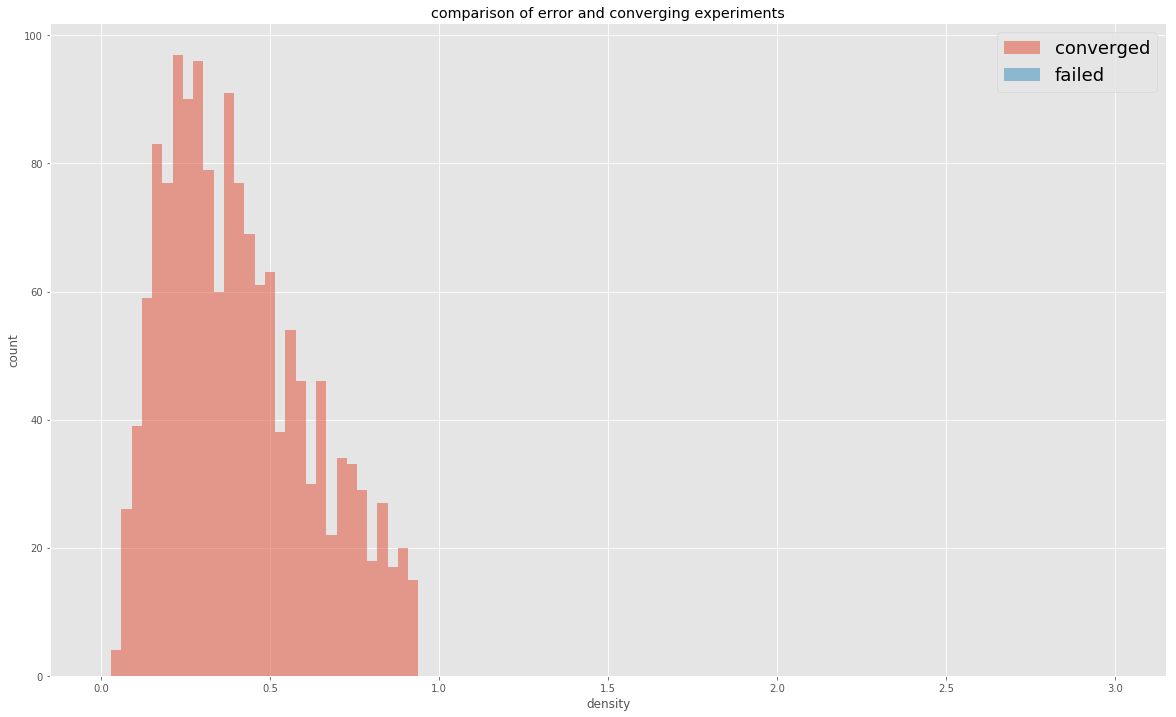

In [14]:
failed = df[df.time.isnull()].density
converged = df[~df.time.isnull()].density

bins = numpy.linspace(0, 3, 100)

plt.hist(converged, bins, alpha=0.5, label='converged')
plt.hist(failed, bins, alpha=0.5, label='failed')
plt.title('comparison of error and converging experiments')
plt.xlabel('density')
plt.ylabel('count')
plt.legend(loc='upper right', prop={'size': 18})
plt.show()

plt.savefig('failures.png')

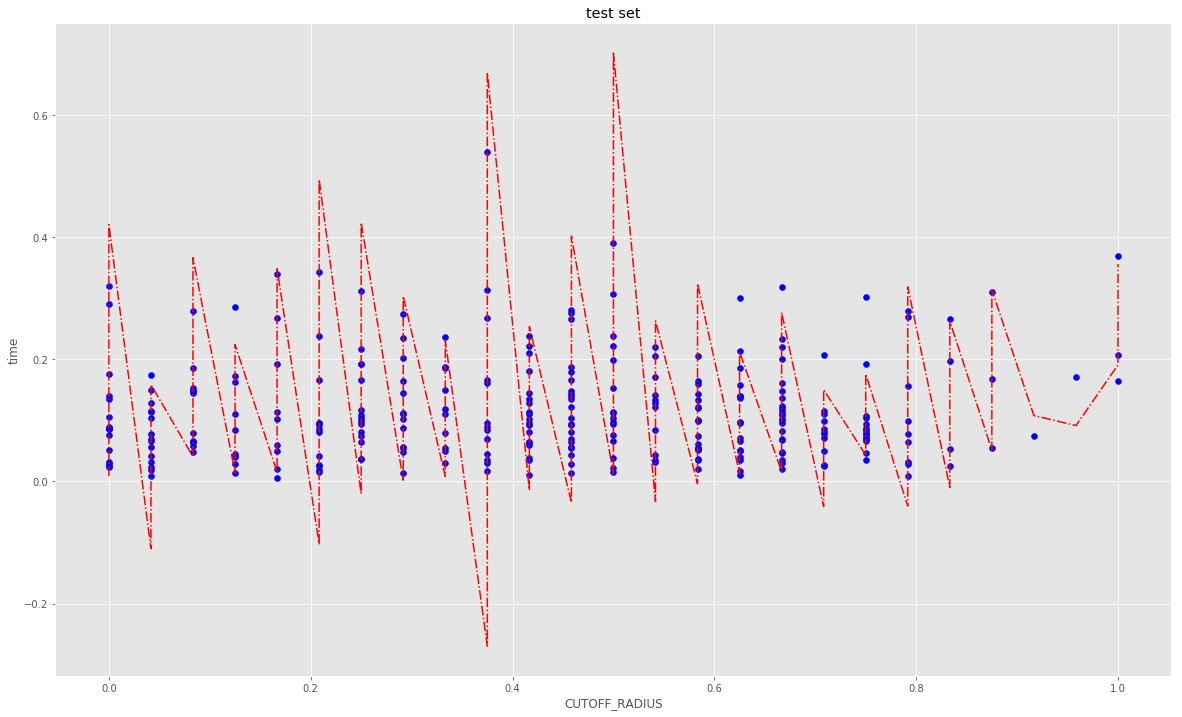

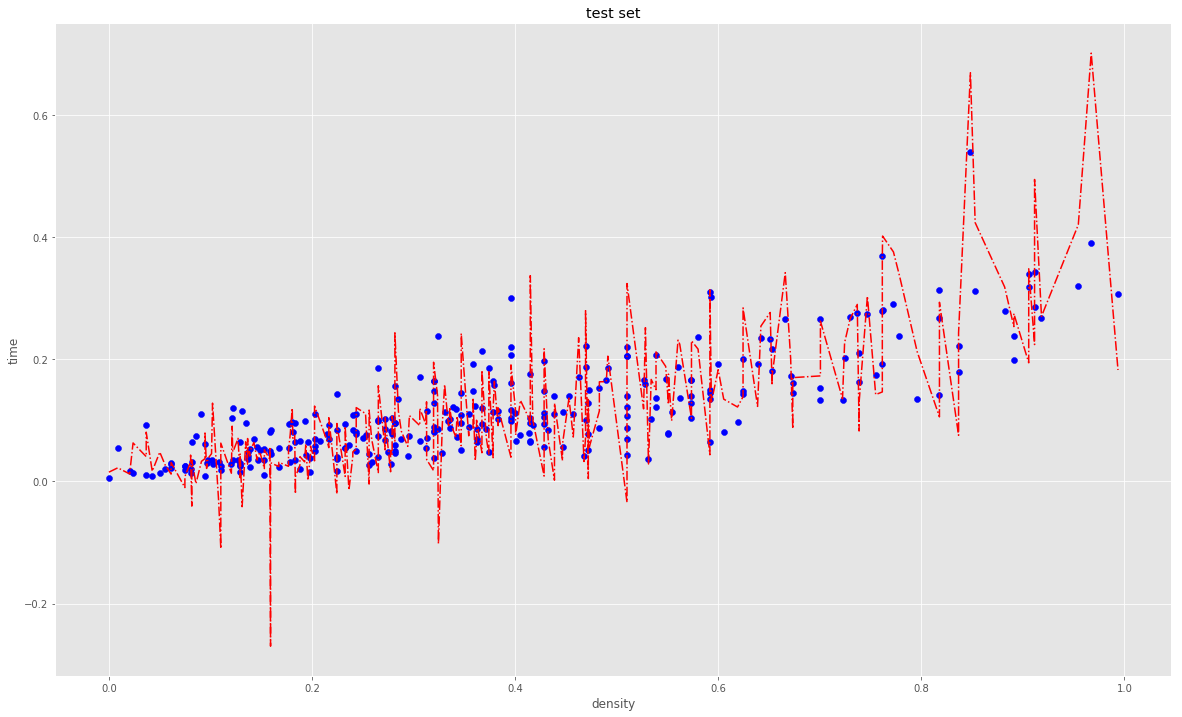

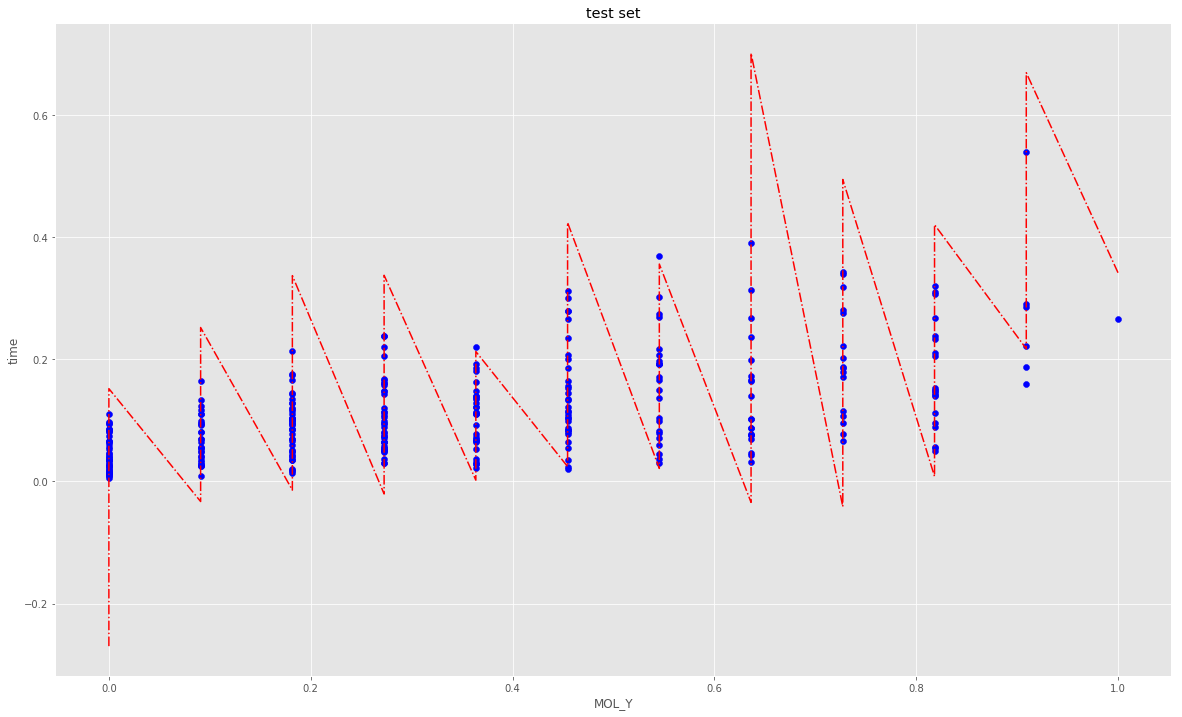

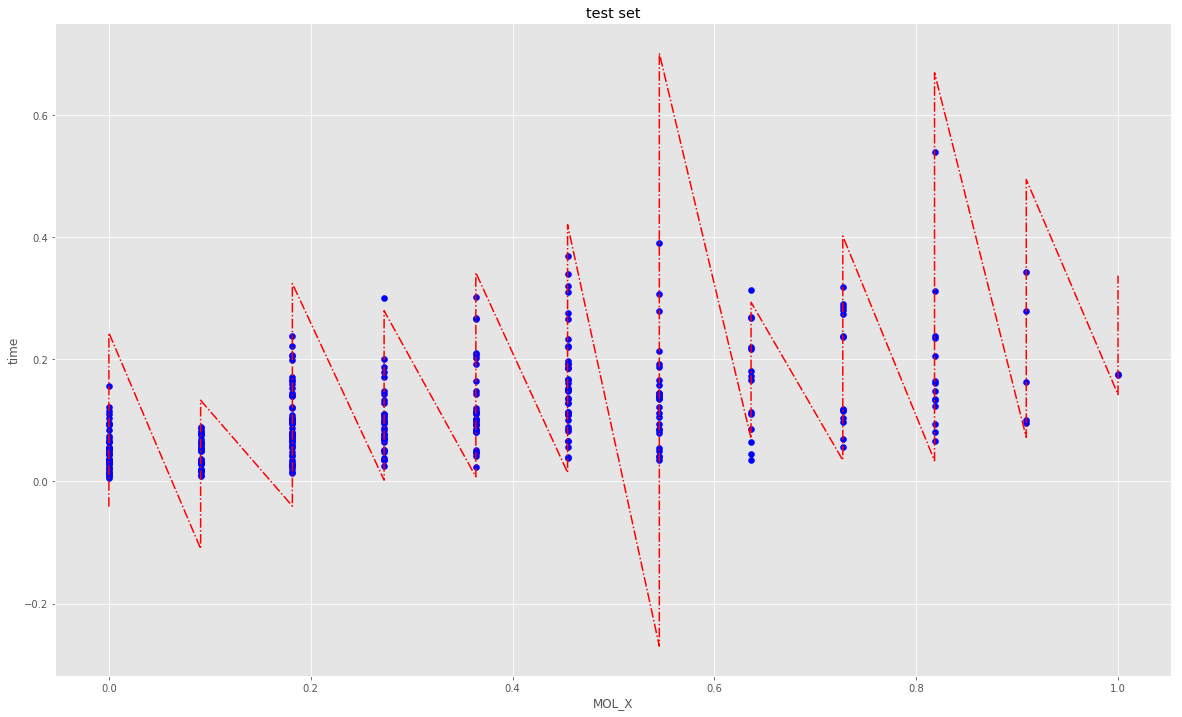

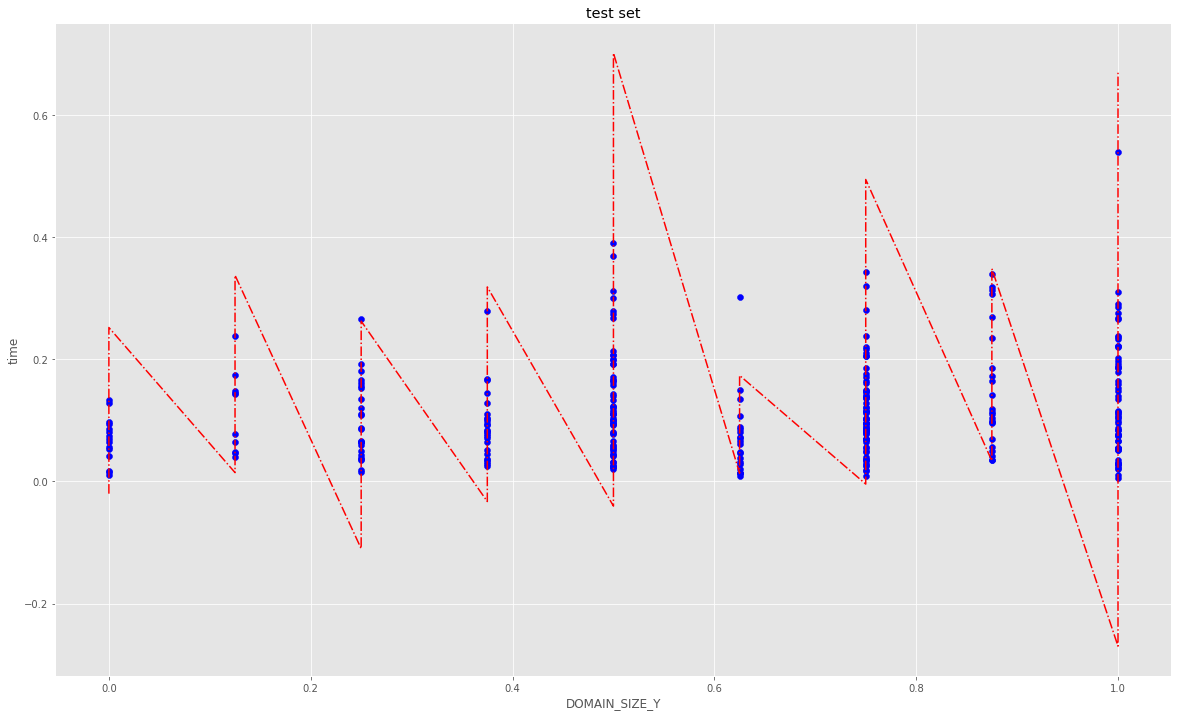

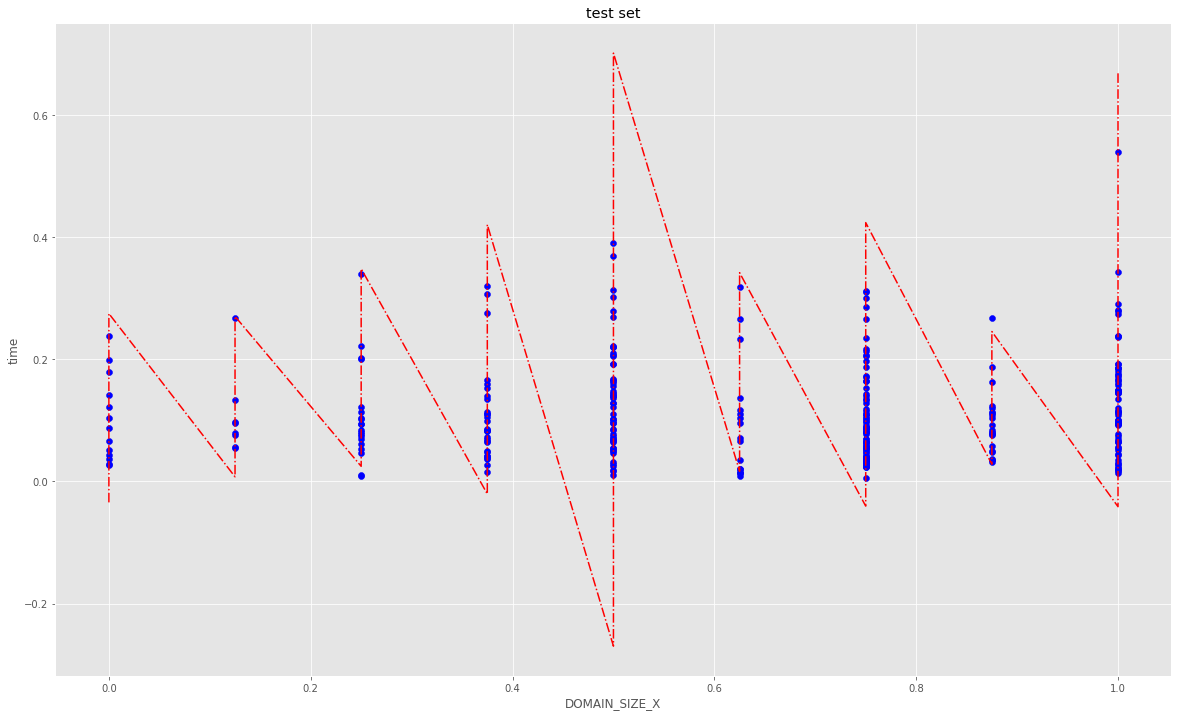

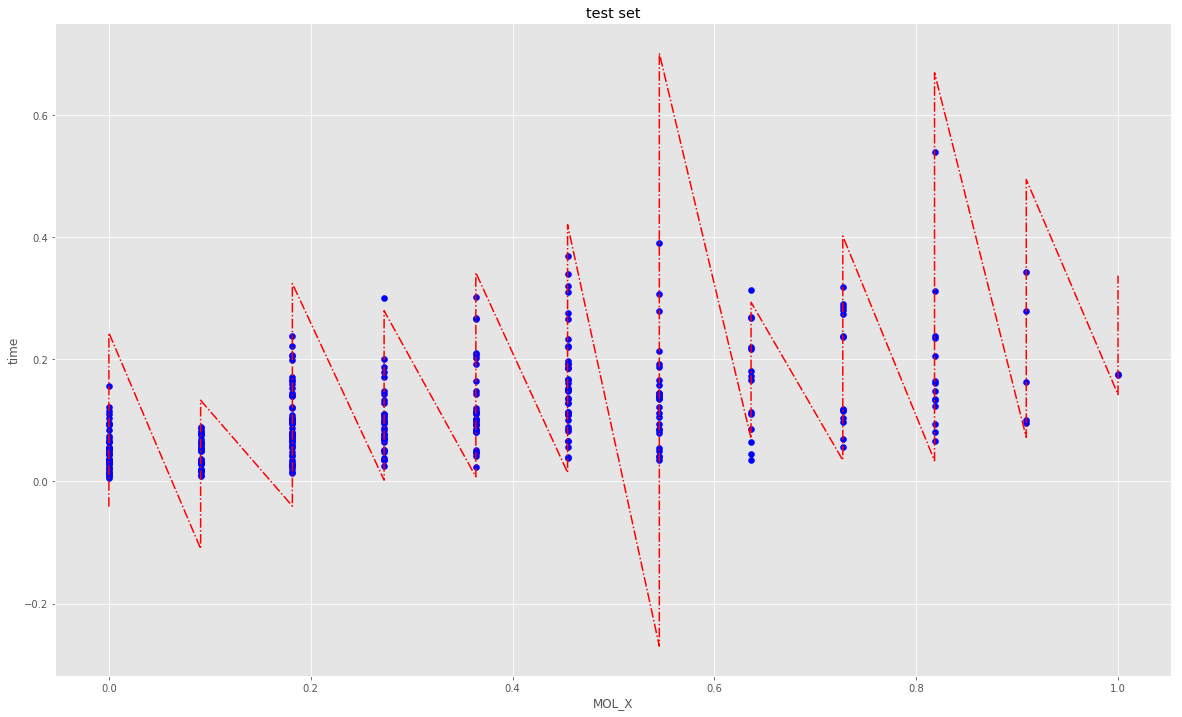

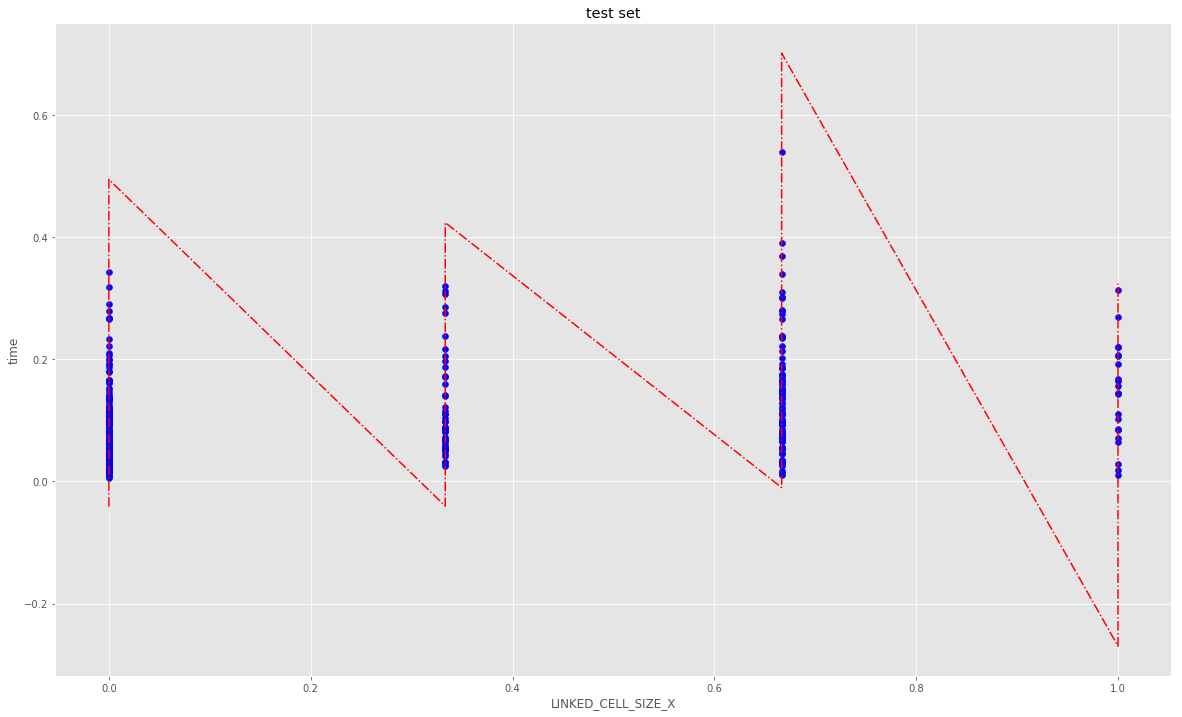

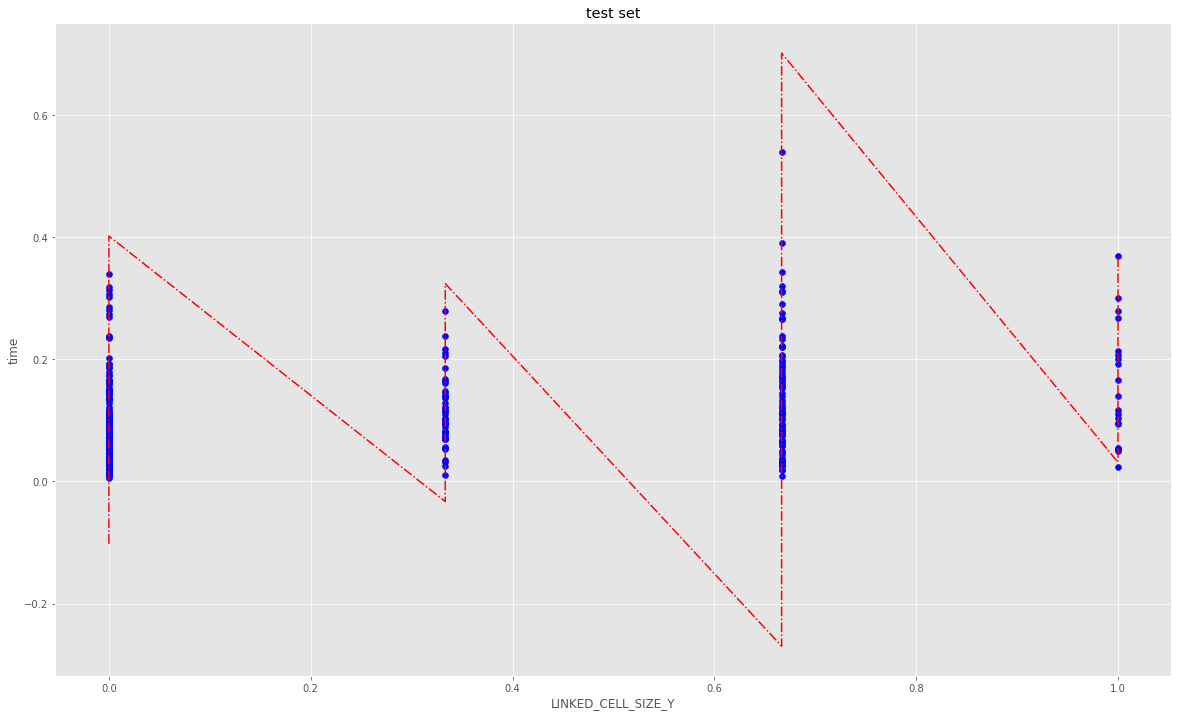

In [15]:
generatePairPlots(X_test, Y_test, learner.grid, learner.alpha, title = 'test set', outdir = '/media/sf_sparse_grids/pairPlots/test')

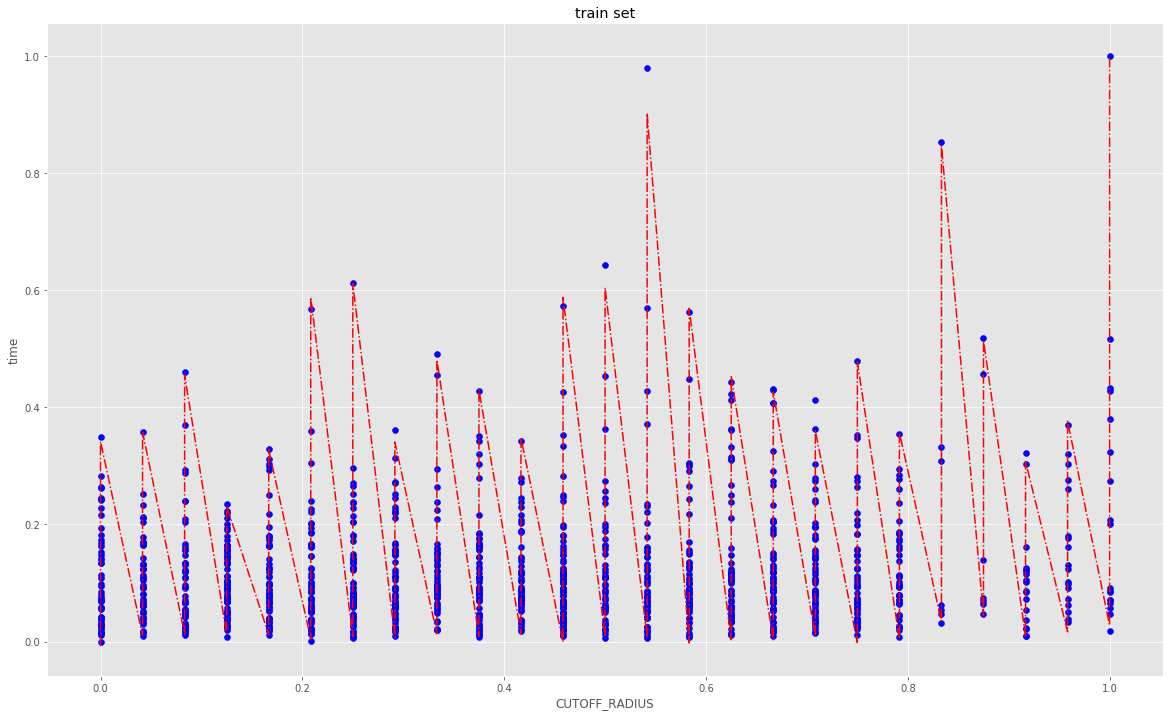

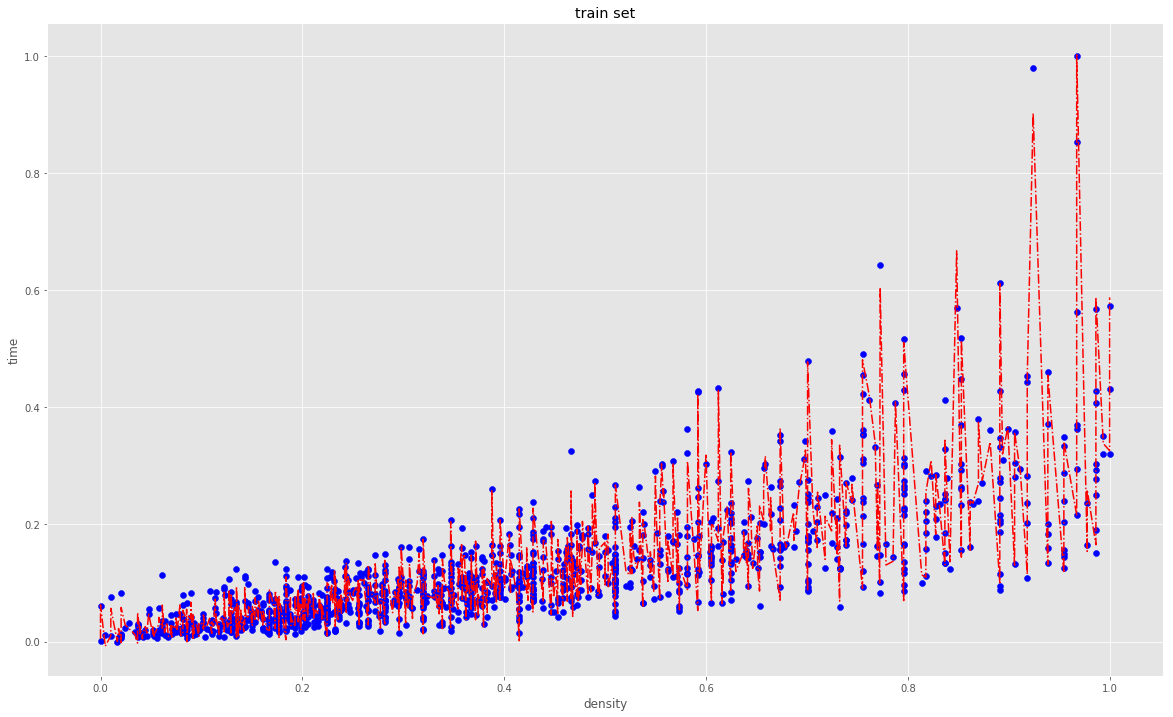

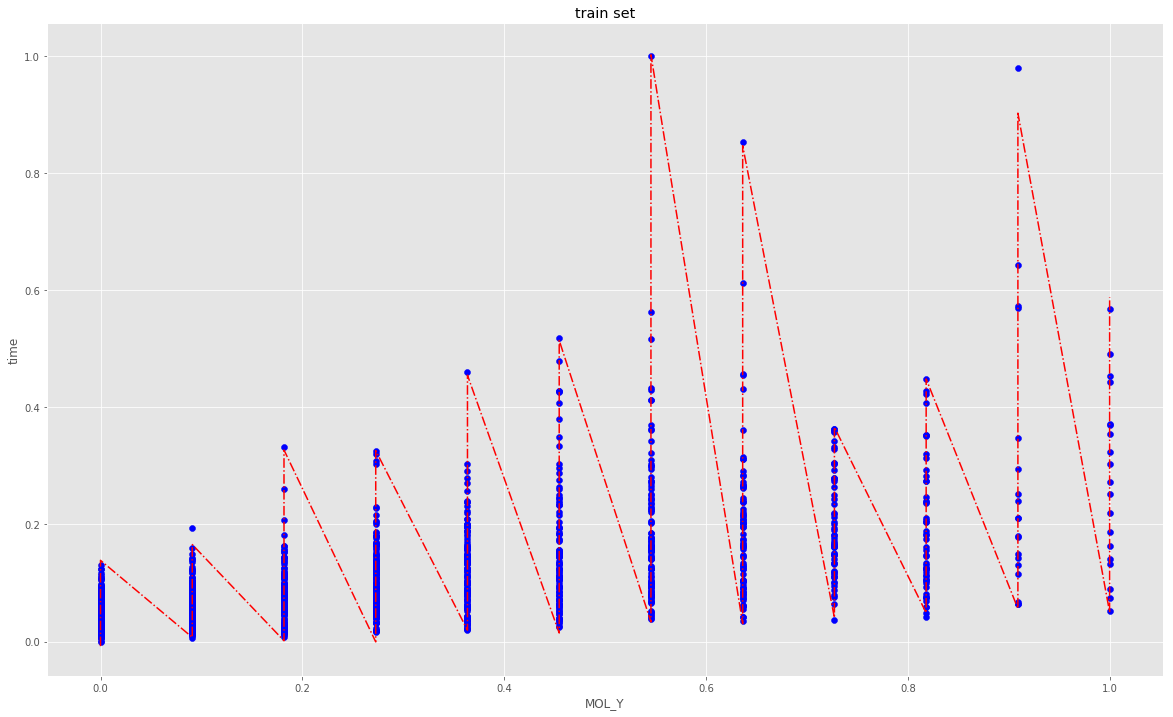

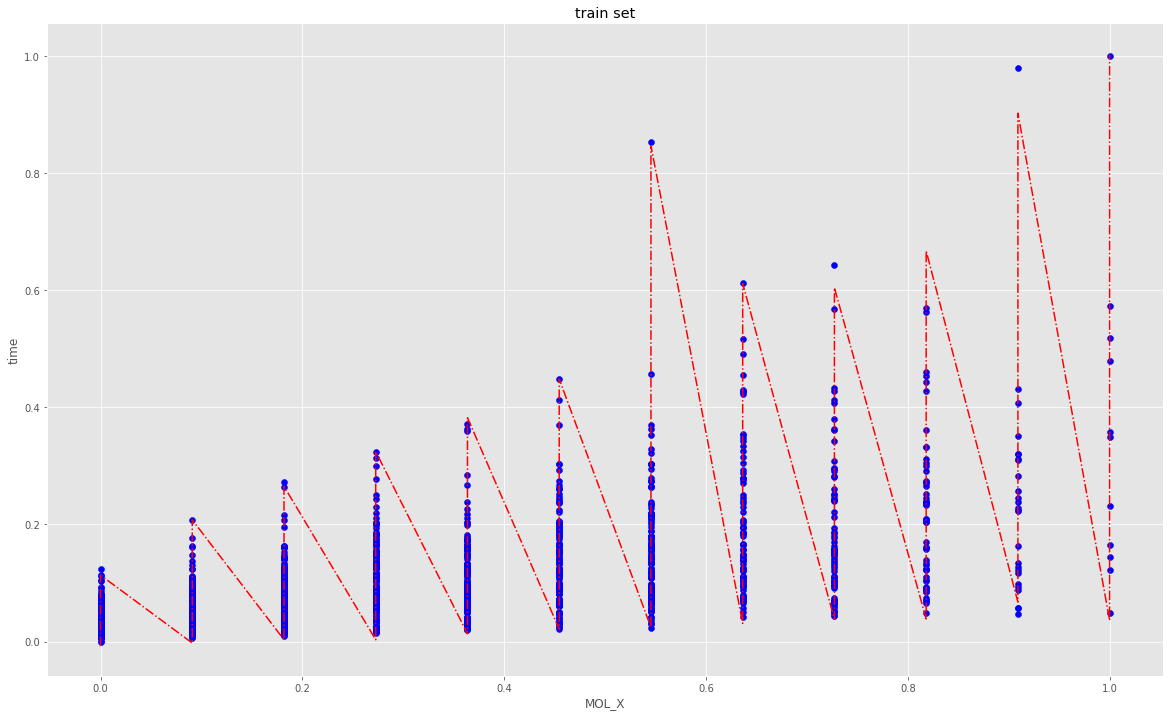

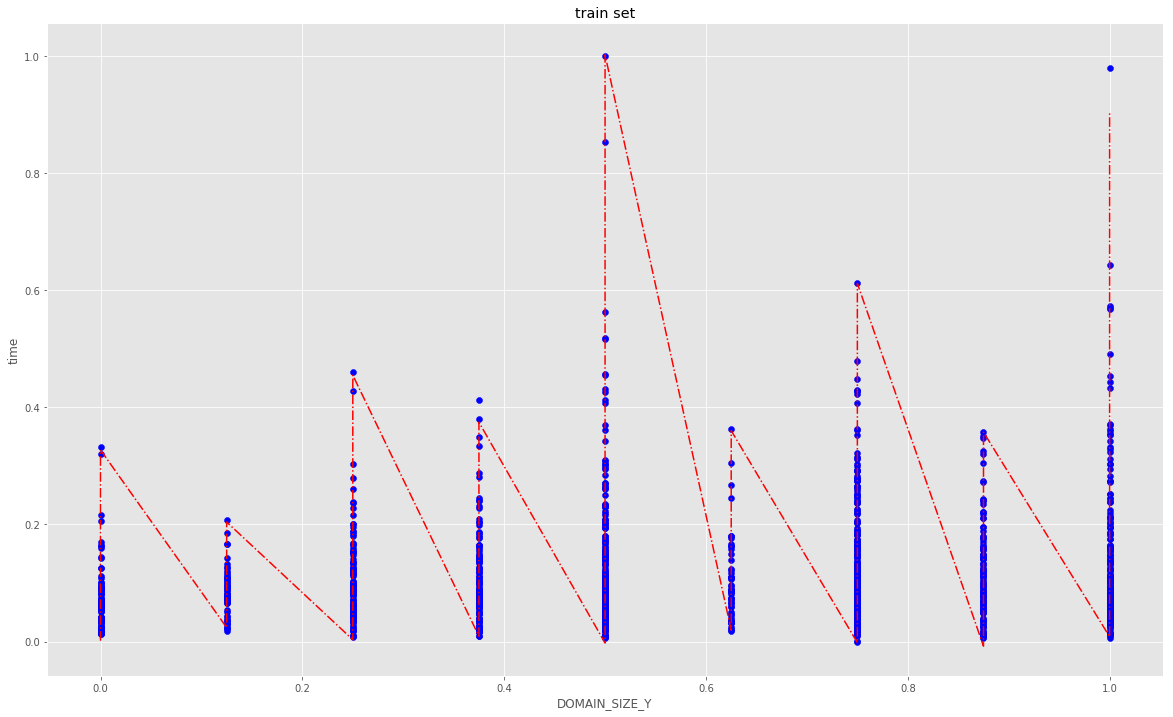

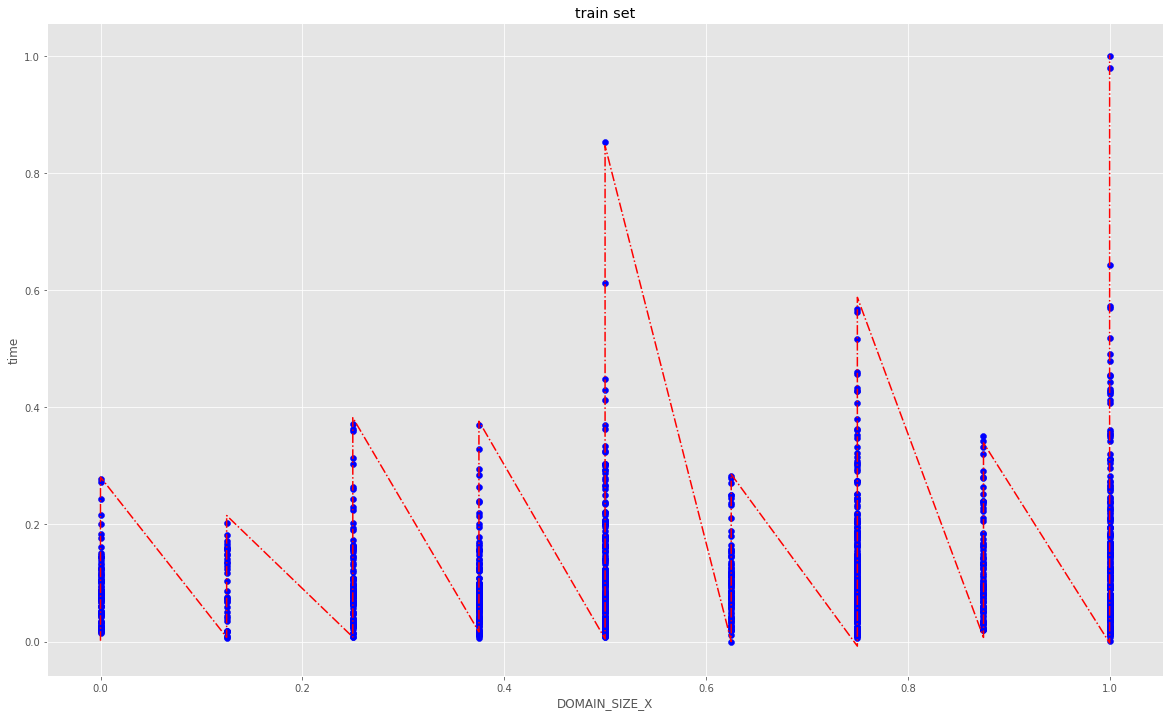

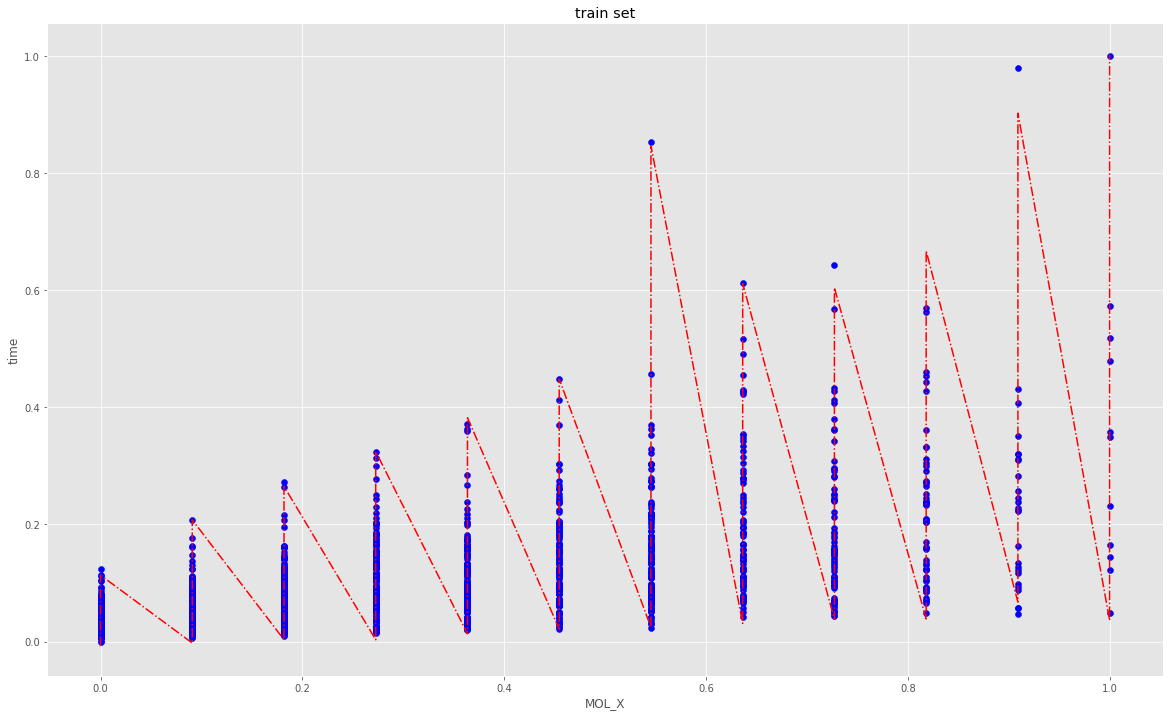

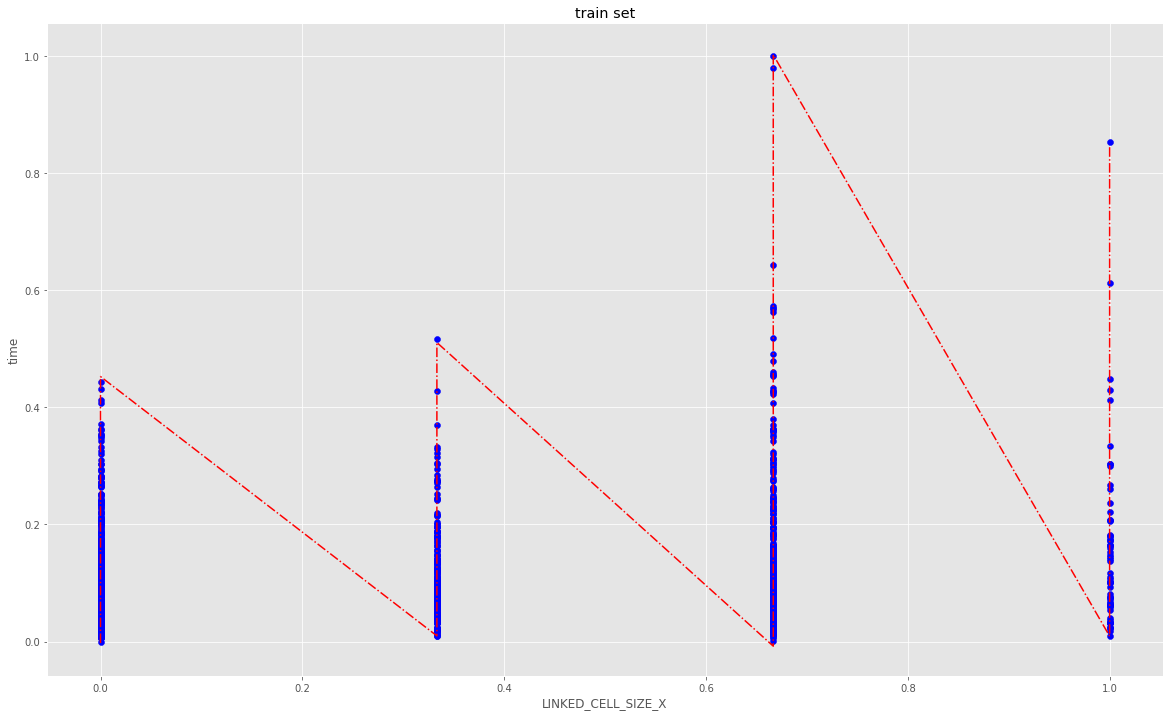

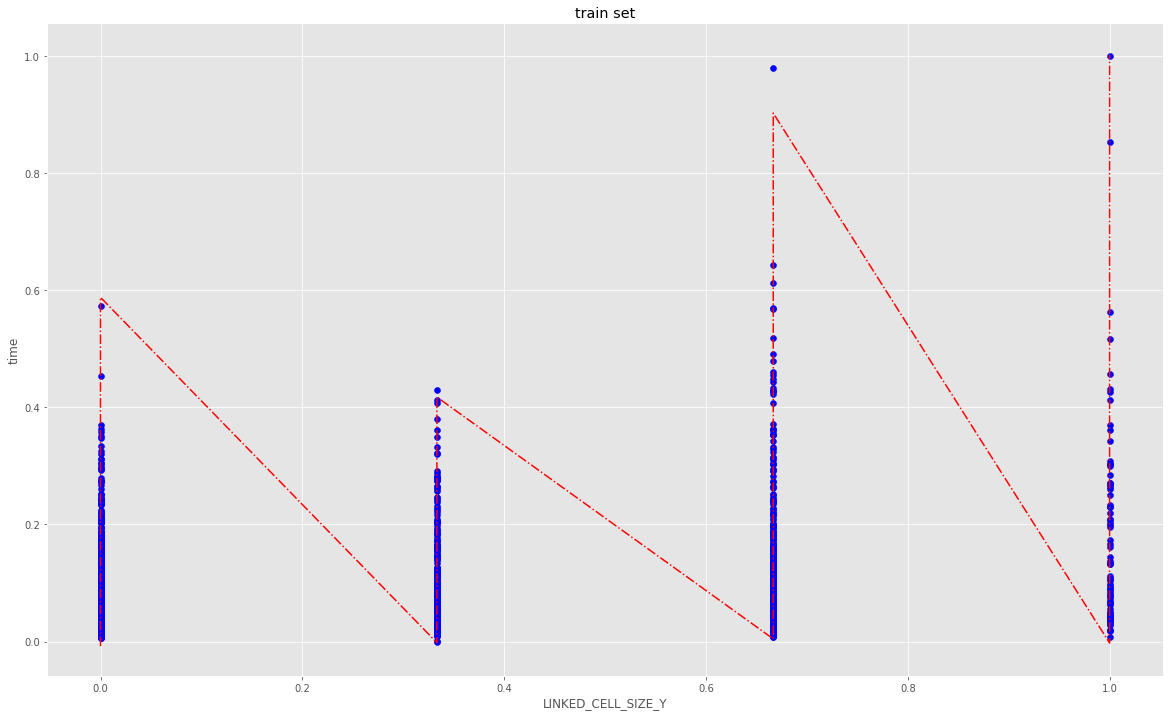

In [16]:
generatePairPlots(X_train, Y_train, learner.grid, learner.alpha, title='train set', outdir = '/media/sf_sparse_grids/pairPlots/train')

In [13]:
# df.to_csv('raw_data_16_1_2018.csv')